In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
locloc = "PreparedNp" 
namename = "\Cube"
all_photos = np.load(locloc + namename + 'Photos.npy')
all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [42]:
def masstest(mylist):
    numlist = mylist 
    intotheflames = list()
    testanswers = list()
    
    intotheflames.append(all_photos[numlist])
    testanswers.append(answerList[numlist])
    
    intotheflames = np.array(intotheflames)[0]
    testanswers = np.array(testanswers)[0]
    print(intotheflames.shape)
    imgimg = model.predict(intotheflames)
    r0 =  np.concatenate(np.take(intotheflames, [0,1,2,3], axis=0), axis=0)
    r1 =  np.concatenate(np.take(imgimg, [0,1,2,3], axis=0), axis=0)
    r2 =  np.concatenate(np.take(testanswers, [0,1,2,3], axis=0), axis=0)
    r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0,r1,r2[..., :3],r3,r4, r5[..., :3]], axis=1)
    return finalimage

(100, 64, 64)


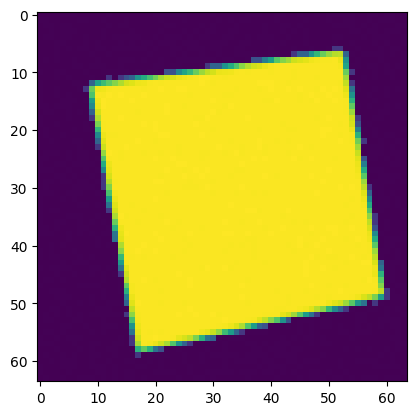

In [4]:
all_one_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_one_masks *= (1.0/all_one_masks.max())
plt.imshow(all_one_masks[0])

print(all_one_masks.shape)

In [66]:
batch_size = 64
train_size = int(0.95 * len(all_photos)) # SMALL DATASET FOR TESTING

#dictDegrees = dict()
#for i in range(len(all_degrees)):
#    dictDegrees[all_degrees[i]] = all_normals[i]
lightjumps = 77
answerList = list()
for i in range(len(all_photos)):
    answerList.append(
        all_normals[i // lightjumps]
        #np.dstack(( herehere , all_one_masks[i // lightjumps]))
    )
            
        
answerList = np.array(answerList)

dataset = tf.data.Dataset.from_tensor_slices((all_photos, answerList))
dataset = dataset.shuffle(buffer_size=512, seed=42)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(64, drop_remainder=True)
test_dataset = test_dataset.batch(64,drop_remainder=True)
print(all_photos.shape, answerList.shape)

(7700, 64, 64, 3) (7700, 64, 64, 3)


114 6


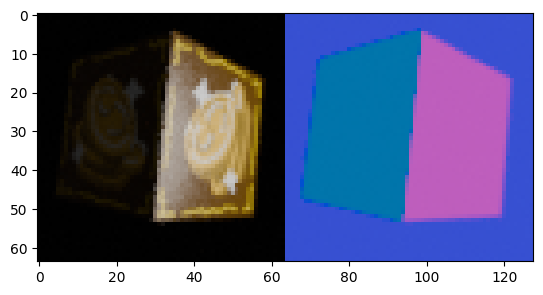

In [68]:
print(len(list(train_dataset)), len(list(test_dataset)))
def PhotoNormalMask(imtoshownum):
    imtoshow = np.concatenate( [
        all_photos[imtoshownum], 
        answerList[imtoshownum][...,: 3], 
        #np.repeat(answerList[imtoshownum][...,3:], 3, axis=2) 
    ]
                              , axis=1).astype("float32")
    plt.imshow(imtoshow)
PhotoNormalMask(1900)

In [86]:
def custom_loss(y_true, y_pred, mask):
    mask = tf.cast(mask, tf.float32)
    masked_y_true = y_true * mask
    masked_y_pred = y_pred * mask
    
    loss = tf.reduce_mean(tf.square(masked_y_true - masked_y_pred))
    return loss

In [87]:
def create_model():
    model = keras.Sequential([
        keras.layers.Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3 * 64 * 64, activation='relu'),
        keras.layers.Reshape((64, 64, 3)),
    ])
    return model

In [94]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.000023)

In [95]:
def loss_function(y_true, y_pred):
    mask = tf.reshape(y_true[..., -1], (64,64,64,1))  # Предполагаем, что маска находится в последнем канале
    return custom_loss(y_true[..., :-1], y_pred, mask)
model = create_model()
model.compile(optimizer=g_optimizer_image, loss="mse")
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 64, 64, 4)         112       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 8, 8, 16)       

In [99]:
model.fit(train_dataset, epochs=50)

Epoch 1/50
114/114 [==============================] - 2s 13ms/step - loss: 0.0100
Epoch 2/50
114/114 [==============================] - 2s 14ms/step - loss: 0.0099
Epoch 3/50
114/114 [==============================] - 2s 14ms/step - loss: 0.0097
Epoch 4/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0096
Epoch 5/50
114/114 [==============================] - 1s 13ms/step - loss: 0.0094
Epoch 6/50
114/114 [==============================] - 1s 13ms/step - loss: 0.0094
Epoch 7/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0092
Epoch 8/50
114/114 [==============================] - 1s 13ms/step - loss: 0.0091
Epoch 9/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0090
Epoch 10/50
114/114 [==============================] - 1s 12ms/step - loss: 0.0089
Epoch 11/50
114/114 [==============================] - 2s 13ms/step - loss: 0.0088
Epoch 12/50
114/114 [==============================] - 2s 14ms/step - loss: 0.0086
Epoch 13/50
1

(8, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
(256, 384, 3)


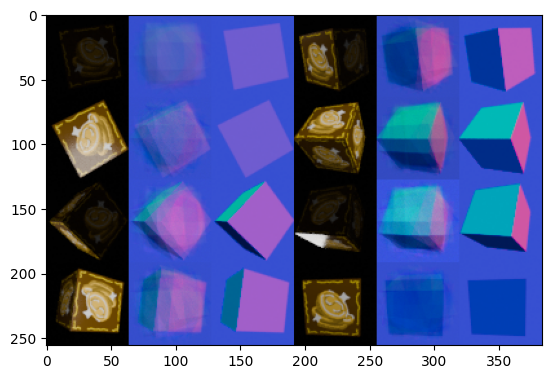

In [100]:
toinset = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]
bigpicture = masstest(toinset)
print(bigpicture.shape)
plt.imshow(bigpicture.astype("float32"))

In [102]:
model.evaluate(train_dataset)

114/114 [==============================] - 1s 8ms/step - loss: 0.0044


0.004351698327809572

In [104]:
#model.save("CubeDropoutMSENormals003.keras")

In [ ]:
# Результаты очень даже ничего.